In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from PIL import Image
from scipy.stats import skew
from matplotlib.transforms import Bbox
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

In [11]:
!pip install opendatasets

In [5]:
import opendatasets as od

# Download a dataset
dataset_url = 'https://www.kaggle.com/datasets/berkanoztas/synthetic-transaction-monitoring-dataset-aml/data'
od.download(dataset_url)

Skipping, found downloaded files in "./synthetic-transaction-monitoring-dataset-aml" (use force=True to force download)


In [2]:
df = pd.read_csv("/content/synthetic-transaction-monitoring-dataset-aml/SAML-D.csv")

In [3]:
df.head()

,Time,Date,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering,Laundering_type
0,10:35:19,2022-10-07,8724731955,2769355426,1459.15,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits
1,10:35:20,2022-10-07,1491989064,8401255335,6019.64,UK pounds,Dirham,UK,UAE,Cross-border,0,Normal_Fan_Out
2,10:35:20,2022-10-07,287305149,4404767002,14328.44,UK pounds,UK pounds,UK,UK,Cheque,0,Normal_Small_Fan_Out
3,10:35:21,2022-10-07,5376652437,9600420220,11895.00,UK pounds,UK pounds,UK,UK,ACH,0,Normal_Fan_In
4,10:35:21,2022-10-07,9614186178,3803336972,115.25,UK pounds,UK pounds,UK,UK,Cash Deposit,0,Normal_Cash_Deposits


In [4]:
df.shape

(9504852, 12)

In [5]:
df['Is_laundering'].value_counts()

,count
Is_laundering,
0,9494979
1,9873


<Axes: xlabel='Is_laundering', ylabel='count'>

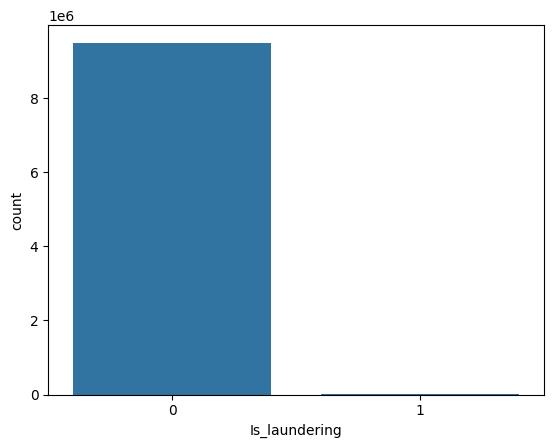

In [6]:
sns.countplot(data = df, x="Is_laundering")

In [7]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df['Is_laundering'] == 0]
df_minority = df[df['Is_laundering'] == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,    # Sample without replacement
                                   n_samples=len(df_minority) * 5,  # Keep a 1:5 ratio
                                   random_state=42)  # Reproducible results

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the combined dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Display class distribution
print("Class distribution after downsampling:")
print(df_balanced['Is_laundering'].value_counts())


Class distribution after downsampling:
Is_laundering
0    49365
1     9873
Name: count, dtype: int64


In [31]:
df = df_balanced

<Axes: xlabel='Is_laundering', ylabel='count'>

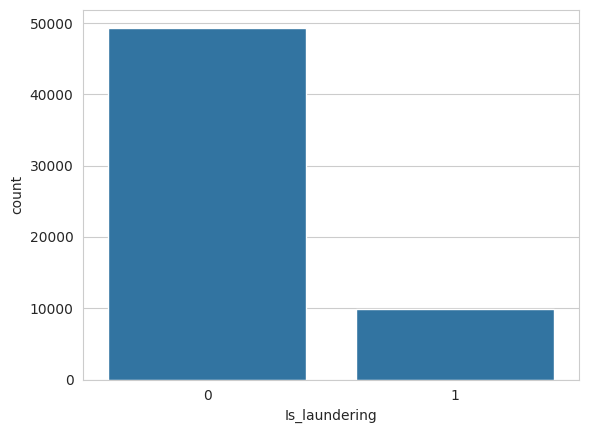

In [32]:
sns.countplot(data = df, x="Is_laundering")

In [33]:
df2 = df.copy()


df2['Date'] = pd.to_datetime(df2['Date'])

# Extract month, day, and week

df2['Year'] = pd.to_datetime(df2['Date']).dt.year
df2['Month'] = pd.to_datetime(df2['Date']).dt.month
df2['Day'] = pd.to_datetime(df2['Date']).dt.day
df2['Week'] = df2['Date'].dt.isocalendar().week

In [34]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59238 entries, 0 to 59237
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Time                    59238 non-null  object        
 1   Date                    59238 non-null  datetime64[ns]
 2   Sender_account          59238 non-null  int64         
 3   Receiver_account        59238 non-null  int64         
 4   Amount                  59238 non-null  float64       
 5   Payment_currency        59238 non-null  object        
 6   Received_currency       59238 non-null  object        
 7   Sender_bank_location    59238 non-null  object        
 8   Receiver_bank_location  59238 non-null  object        
 9   Payment_type            59238 non-null  object        
 10  Is_laundering           59238 non-null  int64         
 11  Laundering_type         59238 non-null  object        
 12  Year                    59238 non-null  int32 

In [36]:
df2.columns

Index(['Time', 'Date', 'Sender_account', 'Receiver_account', 'Amount',
       'Payment_currency', 'Received_currency', 'Sender_bank_location',
       'Receiver_bank_location', 'Payment_type', 'Is_laundering',
       'Laundering_type', 'Year', 'Month', 'Day', 'Week'],
      dtype='object')

<Axes: xlabel='Year', ylabel='count'>

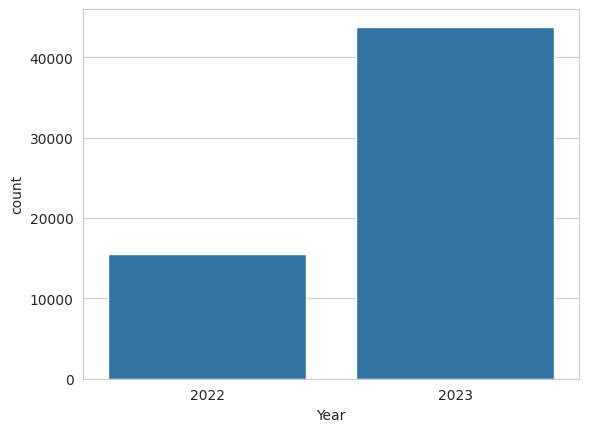

In [37]:
sns.countplot(data=df2, x='Year')

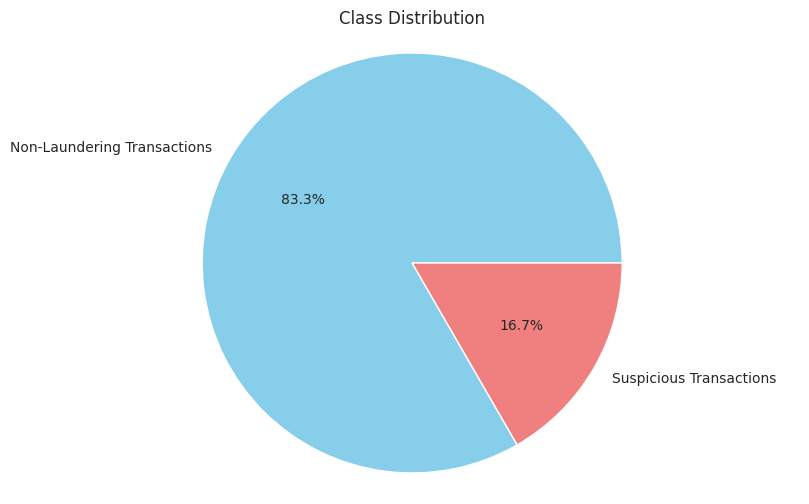

In [38]:
class_distribution = df2['Is_laundering'].value_counts()

plt.figure(figsize=(10, 6))
plt.pie(class_distribution, labels=['Non-Laundering Transactions', 'Suspicious Transactions'], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])

plt.title('Class Distribution')
plt.axis('equal')

plt.show();

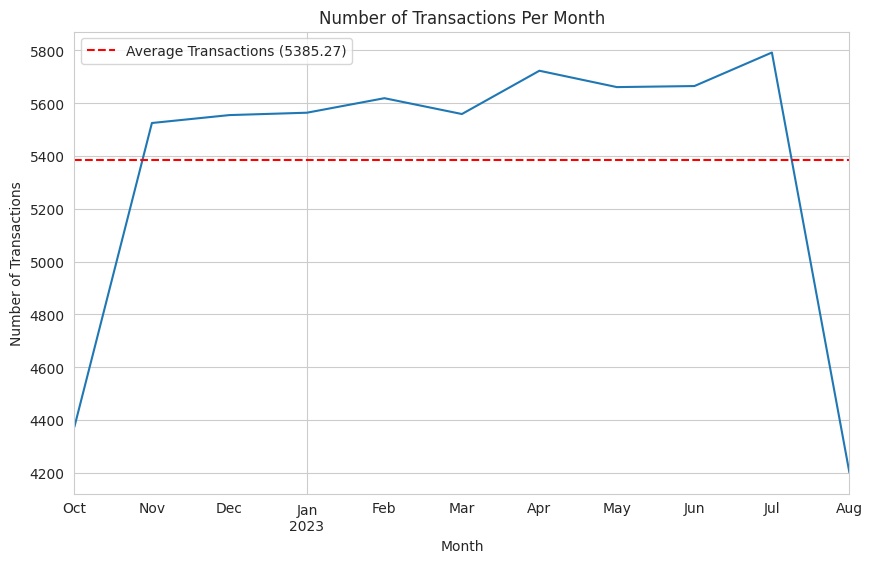

In [39]:
## Monthly Transactions

# Use df2 instead of df
monthly_transactions = df2.groupby(df2['Date'].dt.to_period('M')).size()

# Calculate average monthly transactions
average_monthly_transactions = monthly_transactions.mean()

# Plot the transactions per month
plt.figure(figsize=(10, 6))
monthly_transactions.plot(kind='line')
plt.axhline(y=average_monthly_transactions, color='r', linestyle='--', label=f'Average Transactions ({average_monthly_transactions:.2f})')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions Per Month')
plt.legend()
plt.grid(True)
plt.show()

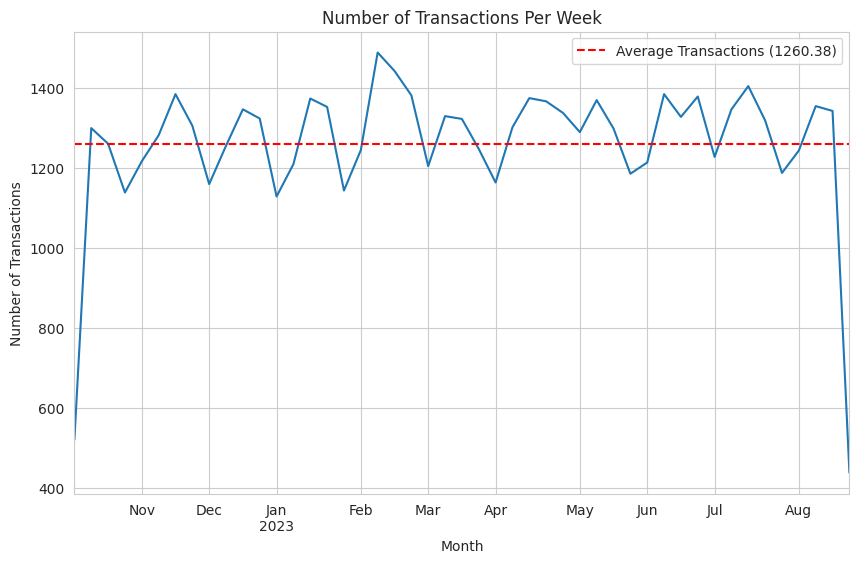

In [40]:
## Weekly Transactions

weekly_transactions = df2.groupby(df2['Date'].dt.to_period('W')).size()

average_weekly_transactions = weekly_transactions.mean()

plt.figure(figsize=(10, 6))
weekly_transactions.plot(kind='line')
plt.axhline(y=average_weekly_transactions, color='r', linestyle='--', label=f'Average Transactions ({average_weekly_transactions:.2f})')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions Per Week')
plt.legend()
plt.grid(True)
plt.show();

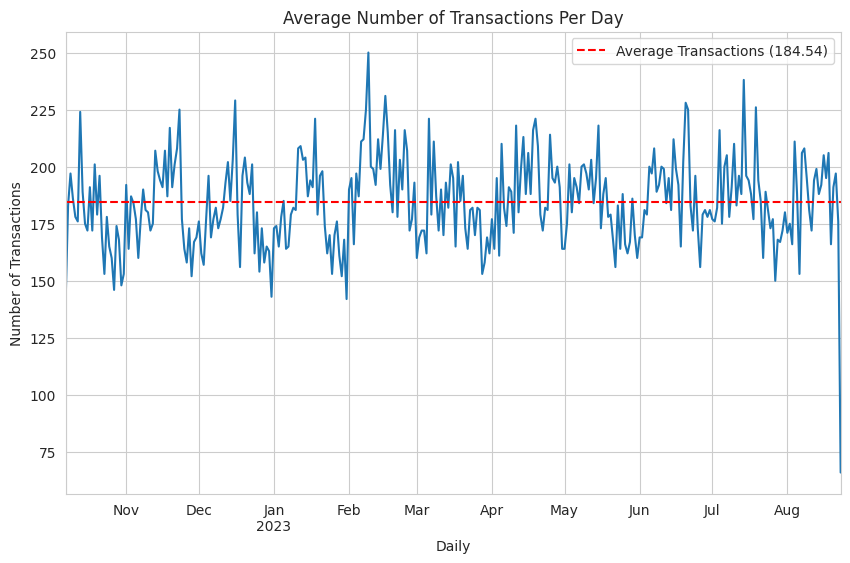

In [41]:
## Daily Transactions

daily_transactions = df2.groupby(df2['Date'].dt.to_period('D')).size()

average_daily_transactions = daily_transactions.mean()


plt.figure(figsize=(10, 6))
daily_transactions.plot(kind='line')
plt.axhline(y=average_daily_transactions, color='r', linestyle='--', label=f'Average Transactions ({average_daily_transactions:.2f})')
plt.xlabel('Daily')
plt.ylabel('Number of Transactions')
plt.title('Average Number of Transactions Per Day')
plt.legend()
plt.grid(True)
plt.show();

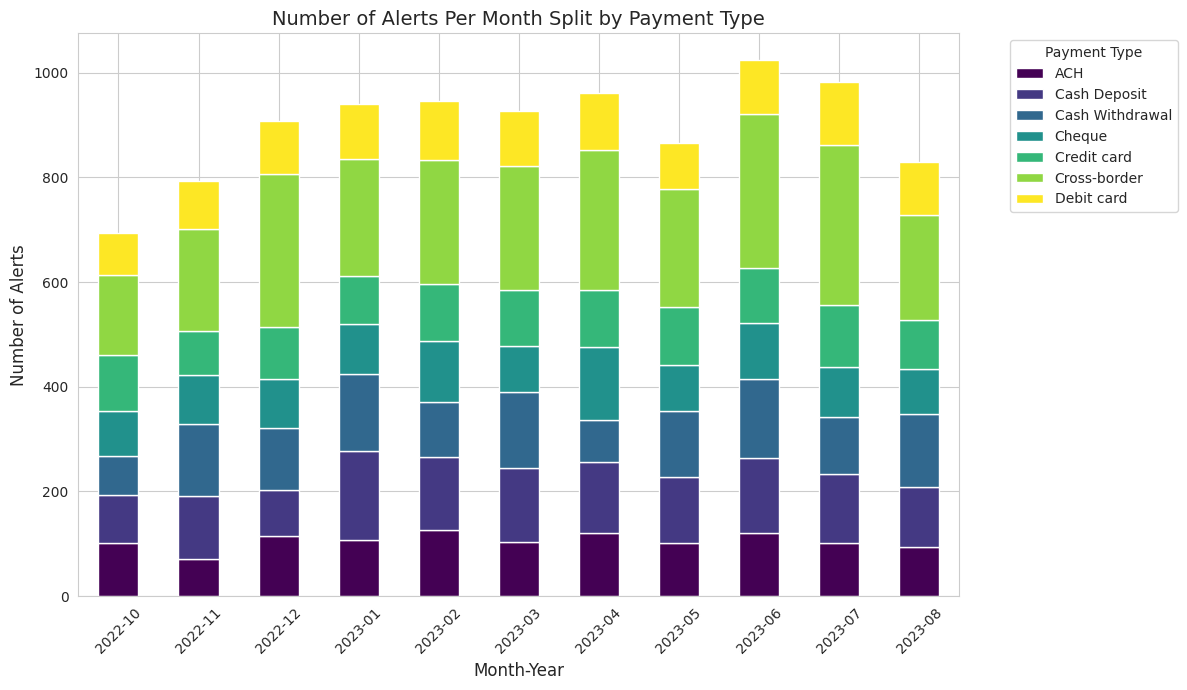

In [42]:
df2['Date'] = pd.to_datetime(df2['Date'])
grouped_data = df2.groupby(['Date', 'Payment_type']).agg({'Is_laundering': 'sum'}).reset_index()
grouped_data['Month_Year'] = grouped_data['Date'].dt.to_period('M')
monthly_alerts = grouped_data.groupby(['Month_Year', 'Payment_type']).agg({'Is_laundering': 'sum'}).reset_index()

pivot_data = monthly_alerts.pivot(index='Month_Year', columns='Payment_type', values='Is_laundering')

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 7))
pivot_data.plot(kind='bar', ax=ax, stacked=True, colormap='viridis')
pivot_data = monthly_alerts.pivot(index='Month_Year', columns='Payment_type', values='Is_laundering')

plt.title('Number of Alerts Per Month Split by Payment Type', fontsize=14)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Number of Alerts', fontsize=12)
plt.xticks(rotation=45)

plt.legend(title='Payment Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show();

In [43]:
df.shape

(59238, 12)

In [44]:
train_start = '2022-10-01'
train_end = '2023-05-31'
test_start = '2023-06-01'
test_end = '2023-08-31'

# Split the data into training and test sets based on the 'Date' column
train_data = df[(df['Date'] >= train_start) & (df['Date'] <= train_end)]
test_data = df[(df['Date'] >= test_start) & (df['Date'] <= test_end)]

In [45]:
train_data.drop(columns=['Laundering_type', 'Time', 'Date'], inplace=True)
test_data.drop(columns=['Laundering_type', 'Time', 'Date'], inplace=True)

In [46]:
from sklearn import preprocessing

In [47]:
test_data.head()

,Sender_account,Receiver_account,Amount,Payment_currency,Received_currency,Sender_bank_location,Receiver_bank_location,Payment_type,Is_laundering
6,564346045,5330470881,1153.62,UK pounds,UK pounds,UK,UK,Debit card,0
7,1160544390,1370099530,8842.42,UK pounds,UK pounds,UK,UK,Credit card,0
8,1334700333,8128755111,298.25,UK pounds,UK pounds,UK,UK,ACH,0
16,2035380551,6499550690,2258.13,UK pounds,UK pounds,UK,UK,ACH,0
17,7920845231,5314432766,6343.45,UK pounds,UK pounds,UK,UK,ACH,0


In [48]:
# Dropping irrelevant columns
train_data.drop(columns=['Sender_account', 'Receiver_account'], inplace=True)
test_data.drop(columns=['Sender_account', 'Receiver_account'], inplace=True)

# Handling categorical variables using One-Hot Encoding
categorical_cols = ['Payment_currency', 'Received_currency', 'Sender_bank_location', 'Receiver_bank_location', 'Payment_type']

# Apply one-hot encoding for train and test data
train_data = pd.get_dummies(train_data, columns=categorical_cols, drop_first=True)
test_data = pd.get_dummies(test_data, columns=categorical_cols, drop_first=True)

# Ensuring the train and test have the same columns
missing_cols = set(train_data.columns) - set(test_data.columns)
for col in missing_cols:
    test_data[col] = 0
test_data = test_data[train_data.columns]


In [49]:
# Check the shape of training and test data
print("Shape of train_data:", train_data.shape)
print("Shape of test_data:", test_data.shape)

Shape of train_data: (43580, 66)
Shape of test_data: (15658, 66)


In [50]:
# Define the target variable
target_col = 'Is_laundering'

# Separate features and target for training and test sets
X_train = train_data.drop(columns=[target_col])
y_train = train_data[target_col]
X_test = test_data.drop(columns=[target_col])
y_test = test_data[target_col]

# Display the shapes to confirm the split
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (43580, 65)
Shape of y_train: (43580,)
Shape of X_test: (15658, 65)
Shape of y_test: (15658,)


In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy on test set:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy on test set: 0.7900114957210371

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.88      0.87     12821
           1       0.41      0.38      0.40      2837

    accuracy                           0.79     15658
   macro avg       0.64      0.63      0.63     15658
weighted avg       0.78      0.79      0.79     15658


Confusion Matrix:
 [[11289  1532]
 [ 1756  1081]]


In [55]:
import pandas as pd

# Define the prediction function
def predict_laundering(Sender_account, Receiver_account, Amount, Payment_currency,
                       Received_currency, Sender_bank_location, Receiver_bank_location,
                       Payment_type):

    # Create a DataFrame from the input values
    input_data = pd.DataFrame({
        'Sender_account': [Sender_account],
        'Receiver_account': [Receiver_account],
        'Amount': [Amount],
        'Payment_currency': [Payment_currency],
        'Received_currency': [Received_currency],
        'Sender_bank_location': [Sender_bank_location],
        'Receiver_bank_location': [Receiver_bank_location],
        'Payment_type': [Payment_type]
    })

    # Drop irrelevant columns (same as during preprocessing)
    input_data.drop(columns=['Sender_account', 'Receiver_account'], inplace=True)

    # Apply one-hot encoding to the categorical columns (same as during preprocessing)
    input_data = pd.get_dummies(input_data, columns=categorical_cols, drop_first=True)

    # Ensure the input_data has the same columns as the train_data (excluding the target column)
    missing_cols = set(train_data.drop(columns=[target_col]).columns) - set(input_data.columns)
    for col in missing_cols:
        input_data[col] = 0
    input_data = input_data[train_data.drop(columns=[target_col]).columns]  # Ensure column order matches train data

    # Predict using the trained model
    prediction = rf_model.predict(input_data)

    # Return the prediction
    return "Laundering" if prediction[0] == 1 else "Not Laundering"

In [56]:
# Example usage
result = predict_laundering(564346045, 5330470881, 1153.62, 'UK pounds', 'UK pounds',
                            'UK', 'UK', 'Debit card')
print("Prediction:", result)

Prediction: Laundering


In [57]:
import pickle

# Save the trained Random Forest model to a pickle file
with open('rf_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)